# 하나의 통합 CSV 파일을 읽어들여 데이터 정제 작업을 수행한 후, 'File' 컬럼의 키워드를 기준으로 데이터를 그룹화하여 주요 통계 지표(평균, 최대값)를 계산합니다. 최종적으로 이 지표들을 바탕으로 감소율('decline_rate')과 유의미성 여부('is_significant')를 산출하여 요약 데이터프레임으로 반환하는 함수입니다.

- Args
    - joint_dir (str): 분석할 데이터가 포함된 단일 CSV 파일의 전체 경로입니다.


- Returns
    - summary_df (pd.DataFrame): 계산된 모든 요약 통계 지표를 담고 있는 데이터프레임.

        - Index: 계산된 통계 지표의 이름들로 구성됩니다.

            - 'intervene_val': 'intervene' 키워드를 포함하는 데이터의 평균값.
            - 'craving_max': 특정 키워드('intervene', 'control', 'end')를 제외한 데이터의 최대값.
            - 'decline_rate': intervene_val을 craving_max로 나눈 값.
            - 'is_significant': decline_rate이 0.9 이하인지 여부를 나타내는 boolean 값.

        - Columns: 데이터 정제(NaN, 음수, 0, 무한대 값 제거) 과정을 통과한 최종 피처(feature)들의 이름.

        - Values: 각 피처에 대해 계산된 통계 지표 값.

In [4]:
import pandas as pd
import numpy as np
import re

def calculate_summary_metrics(joint_dir):
    df = pd.read_csv(joint_dir)
    # 데이터프레임 NaN값 들어있는 열 제거
    df = df.dropna (axis=1)
    
    # 데이터프레임 음수값 들어있는 열 제거
    numeric_cols = df.select_dtypes(include=np.number).columns
    cols_with_negatives = [col for col in numeric_cols if (df[col] < 0).any()]
    
    # 데이터프레임 0, inf, -inf값 들어있는 열 제거
    values_to_remove = [0, np.inf, -np.inf]
    cols_with_unwanted = df[numeric_cols].isin(values_to_remove).any()
    cols_to_drop_unwanted = cols_with_unwanted[cols_with_unwanted].index

    all_cols_to_drop = list(set(cols_with_negatives) | set(cols_to_drop_unwanted))
    df_filtered = df.drop(columns=all_cols_to_drop)

    feature_cols = df_filtered.select_dtypes(include=np.number).columns
    
    # intervene1.csv 가져오기
    intervene_mask = df_filtered['File'].str.contains('intervene', case=False, na=False)
    intervene_means = df_filtered[intervene_mask][feature_cols].mean()

    # end, control, intervene1 제외 열에서(Feature 마다) 가장 높은 값 가져오기
    exclude_keywords = 'intervene|control|end'
    exclude_mask = df_filtered['File'].str.contains(exclude_keywords, case=False, na=False)
    craving_maxes = df_filtered[~exclude_mask][feature_cols].max()
    
    summary_df = pd.DataFrame({
        'intervene_val': intervene_means,
        'craving_max': craving_maxes
    }).T 

    decline_rate = (summary_df.loc['intervene_val'] / summary_df.loc['craving_max'].replace(0, np.nan))
    summary_df.loc['decline_rate'] = decline_rate
    summary_df.loc['is_significant'] = summary_df.loc['decline_rate'] <= 0.9
    
    return summary_df


#### Usage

In [159]:
joint_dir = r'C:\Users\DHLEE\Desktop\features\joined/1_1_011_V2.csv'
calculate_summary_metrics(joint_dir)

,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,LA_RA_HR,LL_LA_HR,LL_RA_HR,Vx_RL_HR,LA_RA_HRV_MeanNN,LL_LA_HRV_MeanNN,LL_RA_HRV_MeanNN,...,LA_RA_rr,LL_LA_rr,LL_RA_rr,Vx_RL_rr,ppg_rr,LA_RA_si,LL_LA_si,LL_RA_si,Vx_RL_si,ppg_si
intervene_val,12.0,0.042256,0.971189,73.661578,73.667586,73.668687,73.665136,814.700704,814.618178,814.618178,...,21.235618,21.235618,21.235618,21.235618,22.280140,7.336022,6.800054,6.147303,6.154741,12.940460
craving_max,10.0,0.967398,1.008107,79.730734,79.725996,79.726315,79.727565,840.837445,840.871711,840.871711,...,23.977489,23.977489,23.977489,23.977489,23.977489,8.736642,7.210610,7.611500,8.061707,15.111202
decline_rate,1.2,0.043680,0.963378,0.923879,0.924010,0.924020,0.923961,0.968916,0.968778,0.968778,...,0.885648,0.885648,0.885648,0.885648,0.929211,0.839684,0.943062,0.807634,0.763454,0.856349
is_significant,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000



# 지정된 폴더의 모든 CSV 파일을 개별 분석하고, 각 결과를 별도의 CSV 파일로 저장하는 함수입니다.

#### Function : analyze_and_save_subjects(args)

- Args:
    - input_folder (str): 원본 데이터 CSV 파일들이 있는 폴더 경로
    - output_folder (str): 결과 CSV 파일을 저장할 폴더 경로


In [163]:
import glob
import os

def analyze_and_save_subjects(input_folder, output_folder):

    os.makedirs(output_folder, exist_ok=True)
    
    csv_files = glob.glob(os.path.join(input_folder, '*.csv'))

    if not csv_files:
        print(f"경고: '{input_folder}' 폴더에서 CSV 파일을 찾을 수 없습니다.")
        return

    for file_path in csv_files:
        subject_id = os.path.basename(file_path)
        print(f"Analyzing: {subject_id}...")
        try:
            subject_results = calculate_summary_metrics(file_path)
            subject_df = pd.DataFrame(subject_results)
            
            output_filename = f"result_{subject_id}"
            output_path = os.path.join(output_folder, output_filename)
            subject_df.to_csv(output_path)

        except Exception as e:
            print(f"'{subject_id}' 파일 처리 중 오류 발생: {e}")
            
    print(f"\n모든 분석이 완료되었습니다. 결과는 '{output_folder}' 폴더에 저장되었습니다.")

#### Usage

In [7]:
# 1. 원본 데이터가 있는 폴더 경로를 지정
DATA_FOLDER = r'C:\Users\DHLEE\Desktop\features\joined'
# 2. 결과 파일을 저장할 폴더 경로를 지정
OUTPUT_FOLDER = r'C:\Users\DHLEE\Desktop\features\results'
analyze_and_save_subjects(DATA_FOLDER, OUTPUT_FOLDER)

Analyzing: 1_1_011_V2.csv...
Analyzing: 1_1_015_V2.csv...
Analyzing: 1_1_025_V1.csv...
Analyzing: 1_1_027_V1.csv...
Analyzing: 1_1_028_V1.csv...
Analyzing: 1_1_029_V1.csv...
Analyzing: 1_1_034_V1.csv...
Analyzing: 1_1_035_V1.csv...
Analyzing: 1_1_036_V1.csv...

모든 분석이 완료되었습니다. 결과는 'C:\Users\DHLEE\Desktop\features\results' 폴더에 저장되었습니다.


지정된 폴더(directory) 내의 모든 CSV 파일을 읽어, 각 파일에서 'decline_rate' 행의 데이터를 추출합니다. 이 데이터들을 하나의 데이터프레임으로 병합한 후, 모든 파일에 공통으로 존재하는 피처(feature)들만 남겨 최종 결과를 반환하는 함수입니다.

- Args
    - directory_path (str): 요약 정보가 담긴 CSV 파일들이 저장되어 있는 폴더의 경로입니다.

- Returns
    - pd.DataFrame: 아래 두 가지 경우 중 하나에 해당하는 데이터프레임을 반환합니다.
        - Index: 원본 CSV 파일의 이름 (예: 'result_1_01_011_V1.csv').
        - Columns: 모든 CSV 파일에서 공통으로 발견된 피처(feature)들의 이름.
        - Values: 각 파일의 피처별 decline_rate 값.


In [161]:
def combine_decline_rates(directory_path):
    try:
        csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
        if not csv_files:
            raise FileNotFoundError("지정된 경로에 CSV 파일이 없습니다.")
        print(f"총 {len(csv_files)}개의 요약 CSV 파일을 대상으로 작업을 시작합니다...")

    except FileNotFoundError as e:
        print(e)
        return

    all_decline_rates = []
    for filename in csv_files:
        filepath = os.path.join(directory_path, filename)
        try:
            summary_df = pd.read_csv(filepath, index_col=0)
            
            if 'decline_rate' in summary_df.index:
                decline_rate_series = summary_df.loc['decline_rate']
                decline_rate_series.name = filename
                all_decline_rates.append(decline_rate_series)
            else:
                print(f"  - 경고: '{filename}' 파일에 'decline_rate' 행이 없습니다.")
                
        except Exception as e:
            print(f"  - 오류: '{filename}' 파일을 처리하는 중 문제가 발생했습니다: {e}")

    if all_decline_rates:
        final_df = pd.concat(all_decline_rates, axis=1).T
        final_common_df = final_df.dropna(axis=1)
        
        print("\n--- 최종 결과: 공통 피쳐의 decline_rate ---")
        return final_common_df
    else:
        print("\n처리할 데이터가 없습니다.")
        return pd.DataFrame()

#### Usage

In [162]:
decline_rates_series = combine_decline_rates(OUTPUT_FOLDER).max()
significant_features_dict = decline_rates_series[decline_rates_series <= 0.9].to_dict()

print(significant_features_dict)

총 9개의 요약 CSV 파일을 대상으로 작업을 시작합니다...

--- 최종 결과: 공통 피쳐의 decline_rate ---
{'SCR_Peaks_Amplitude_Mean': 0.8891439114604184, 'LA_RA_HRV_SDNN': 0.781120811903403, 'LA_RA_HRV_CVNN': 0.7928228071548529, 'LA_RA_HRV_MadNN': 0.8749999999999999, 'LL_RA_HRV_MadNN': 0.8749999999999999, 'Vx_RL_HRV_MadNN': 0.8461538461538463, 'LA_RA_HRV_MCVNN': 0.8988326848249018, 'LL_RA_HRV_MCVNN': 0.8999999999999994, 'Vx_RL_HRV_MCVNN': 0.868189102564101, 'LA_RA_HRV_IQRNN': 0.8762886597938144, 'LA_RA_HRV_SDRMSSD': 0.8812030547736109, 'LL_LA_HRV_SDRMSSD': 0.889684232560443, 'Vx_RL_HRV_SDRMSSD': 0.7401529569555488, 'LA_RA_HRV_HF': 0.6233960209652554, 'LL_LA_HRV_HF': 0.7770359136180441, 'LL_RA_HRV_HF': 0.6409159846584547, 'LA_RA_HRV_TP': 0.8870037156009392, 'LL_LA_HRV_TP': 0.6465275432266979, 'LL_RA_HRV_TP': 0.6489227718033734, 'LA_RA_HRV_HFn': 0.8095975956849272, 'LL_LA_HRV_HFn': 0.8906574799898224, 'LL_RA_HRV_HFn': 0.8136616213500715, 'Vx_RL_HRV_HFn': 0.8235272218681043, 'LA_RA_HRV_SD2': 0.7657918802787338, 'LA_RA_HRV

# ------------------
# 민석형님 코드 재사용
# ------------------

In [10]:
def safe_corr(x, y, min_samples=10):
    """
    민석형님 코드 재사용
    """
    # 두 벡터를 DataFrame으로 묶음
    df_xy = pd.DataFrame({"x": x, "y": y})

    # Inf → NaN 변환 후, NaN 값 제거
    df_xy = df_xy.replace([np.inf, -np.inf], np.nan).dropna()

    # 샘플 수 부족 시 NaN 반환
    if len(df_xy) < min_samples:
        return np.nan

    # x 또는 y가 상수열(값이 모두 동일)일 경우 NaN 반환
    if df_xy["x"].nunique() <= 1 or df_xy["y"].nunique() <= 1:
        return np.nan

    # Pearson correlation 계산
    return df_xy["x"].corr(df_xy["y"])  # 기본값 method='pearson'


def compute_correlations(feature_df, label_df, label_name="label", min_samples=10):
    """
    민석형님 코드 재사용
    """
    # "File" 기준으로 feature와 label 병합
    df = pd.merge(label_df, feature_df, on="File", how="inner")
    
    # 수치형 데이터만 선택 + Inf → NaN 처리
    numeric_df = df.select_dtypes(include=["number"]).replace([np.inf, -np.inf], np.nan)

    # label_name 컬럼이 없으면 None 반환
    if label_name not in numeric_df.columns:
        return None
    
    # label 벡터 추출
    y = numeric_df[label_name]
    corr_vals = {}

    # 각 feature별로 safe_corr 실행
    for col in numeric_df.columns:
        if col == label_name:
            continue
        corr_vals[col] = safe_corr(numeric_df[col], y, min_samples=min_samples)

    # feature별 correlation 결과 반환 (Series)
    return pd.Series(corr_vals)

def process_labels(label_df, label_name="label", method="mean", cut_bins=None):
    """
    민석형님 코드 재사용
    """

    # Q1, Q2 기반 라벨 계산 (평균 / 최소 / 최대)
    if method == "mean":
        label_df[label_name] = label_df[["Q1", "Q2"]].mean(axis=1)
    elif method == "min":
        label_df[label_name] = label_df[["Q1", "Q2"]].min(axis=1)
    elif method == "max":
        label_df[label_name] = label_df[["Q1", "Q2"]].max(axis=1)
    else:
        # 지정되지 않은 method일 경우 예외 발생
        raise ValueError(f"Unknown method: {method}")
    
    # cut_bins가 주어지면 → 연속형 값을 범주형(클래스)으로 변환
    if cut_bins:
        label_df[label_name] = pd.cut(
            label_df[label_name],              # 변환할 값
            bins=cut_bins,                     # 구간 경계값
            labels=list(range(len(cut_bins)-1)) # 0,1,2,... 라벨링
        ).astype(int)

    # File, label_name만 반환 (다른 열은 버림)
    return label_df[["File", label_name]]


def load_subject_data(fname, joined_dir = r"../features/joined", label_dir = r"../features/label"):
    """
    민석형님 코드 재사용
    """
    # joined feature 파일 경로
    jp = os.path.join(joined_dir, fname)
    # label 파일 경로
    lp = os.path.join(label_dir, fname)

    # label 파일이 없으면 None 반환 (joined만 있는 경우 무시)
    if not os.path.exists(lp):
        return None

    # joined feature CSV 로드
    joined_df = pd.read_csv(jp)
    # label CSV 로드 (File, Q1, Q2만 추출)
    label_df  = pd.read_csv(lp)

    # feature DataFrame, label DataFrame 반환
    return joined_df, label_df[["File", "Q1", "Q2"]]

def get_corr(file_list=None, cut_bins=[-np.inf, 1, 3, np.inf], label_name="label",
             joined_dir = r"../features/joined", label_dir = r"../features/label"):
    """
    민석 형님 코드 재사용
    """
    all_corr = []  # subject별 correlation 결과 저장용 리스트

    # -------------------- (1) subject 파일 순회 --------------------
    for fname in os.listdir(joined_dir):
        if not fname.endswith(".csv"):   # CSV 파일만 처리
            continue
        subject = fname[:-4]             # 파일명에서 확장자 제거 → subject ID

        # file_list가 지정되어 있으면 해당 subject만 처리
        if file_list and subject not in file_list:
            continue

        # -------------------- (2) 데이터 로드 --------------------
        data = load_subject_data(fname, joined_dir, label_dir)
        if data is None:
            continue
        joined_df, label_df = data

        # -------------------- (3) 라벨 처리 --------------------
        # Q1, Q2 → method("mean") 방식으로 통합 후,
        # cut_bins 기준으로 클래스화
        processed_label_df = process_labels(
            label_df,
            label_name=label_name,
            method="mean",
            cut_bins=cut_bins
        )

        # -------------------- (4) feature–label correlation 계산 --------------------
        corr_vals = compute_correlations(joined_df, processed_label_df, label_name=label_name)
        if corr_vals is None:
            continue

        # Series에 subject 이름 붙여 저장
        corr_vals.name = subject
        all_corr.append(corr_vals)

    # -------------------- (5) 모든 subject correlation 합치기 --------------------
    corr_df = pd.concat(all_corr, axis=1)

    # -------------------- (6) feature별 mean correlation 추가 --------------------
    valid_counts = corr_df.count(axis=1)             # NaN 제외한 subject 수
    mean_corr = corr_df.mean(axis=1, skipna=True)    # feature별 평균 correlation
    mean_corr[valid_counts < 5] = np.nan             # subject 수가 적으면 NaN 처리
    corr_df["mean_corr"] = mean_corr

    return corr_df


#### Usage

In [166]:
label_path = r'C:\Users\DHLEE\Documents\GitHub\CravingBiomarkers\features\label'
# corr_df = get_corr(joined_dir=DATA_FOLDER, label_dir=label_path)
get_corr(joined_dir=DATA_FOLDER, label_dir=label_path)

,1_1_011_V2,1_1_015_V2,1_1_025_V1,1_1_027_V1,1_1_028_V1,1_1_029_V1,1_1_034_V1,1_1_035_V1,1_1_036_V1,mean_corr
SCR_Peaks_N,-0.031377,0.379325,0.259134,0.185273,0.243599,0.087330,-0.465910,0.379649,0.376973,0.157111
SCR_Peaks_Amplitude_Mean,-0.068067,-0.107439,-0.066134,0.165014,0.184168,-0.185752,-0.003056,0.066122,0.249837,0.026077
EDA_Tonic_SD,-0.092427,0.273401,0.128271,-0.456785,-0.325019,0.061596,-0.133443,0.162973,-0.421541,-0.089220
EDA_Sympathetic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDA_SympatheticN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
ppg_HRV_MFDFA_alpha2_Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ppg_HRV_MFDFA_alpha2_Delta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ppg_HRV_MFDFA_alpha2_Asymmetry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ppg_HRV_MFDFA_alpha2_Fluctuation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# mean corr 추출하여 DataFrame의 특정 열에 있는 상관계수 값의 부호를 분류하는 딕셔너리를 생성하는 함수입니다.

#### Function generate_corr_sign_dict(Args)

- Args:
    - corr_df (pd.DataFrame): 상관계수 데이터가 포함된 DataFrame 입니다.

- Returns:
    - dict: 피처 이름을 키(key)로, 'pos' 또는 'neg'를 값(value)으로 갖는 딕셔너리 입니다.
        - Key: CSV 파일에서 공통으로 발견된 피처(feature)들의 이름.
        - Values: pos or neg.
            - 값이 양수이면 'pos'로 매핑함
            - 값이 음수이면 'neg'로 매핑함
            - NaN 또는 0인 값은 무시함
    

In [11]:
def generate_corr_sign_dict(corr_df):
    corr_sign_dict = {
        feature: 'pos' if value > 0 else 'neg'
        for feature, value in corr_df.dropna().items() if value != 0
    }
    return corr_sign_dict

#### Usage

In [164]:
all_sign_dict = generate_corr_sign_dict(corr_df['mean_corr'])

generate_corr_sign_dict(corr_df['mean_corr'])

{'SCR_Peaks_N': 'pos',
 'SCR_Peaks_Amplitude_Mean': 'pos',
 'EDA_Tonic_SD': 'neg',
 'LA_RA_HR': 'pos',
 'LL_LA_HR': 'pos',
 'LL_RA_HR': 'pos',
 'Vx_RL_HR': 'pos',
 'LA_RA_HRV_MeanNN': 'neg',
 'LL_LA_HRV_MeanNN': 'neg',
 'LL_RA_HRV_MeanNN': 'neg',
 'Vx_RL_HRV_MeanNN': 'neg',
 'LA_RA_HRV_SDNN': 'pos',
 'LL_LA_HRV_SDNN': 'pos',
 'LL_RA_HRV_SDNN': 'pos',
 'Vx_RL_HRV_SDNN': 'pos',
 'LA_RA_HRV_RMSSD': 'pos',
 'LL_LA_HRV_RMSSD': 'pos',
 'LL_RA_HRV_RMSSD': 'pos',
 'Vx_RL_HRV_RMSSD': 'pos',
 'LA_RA_HRV_SDSD': 'pos',
 'LL_LA_HRV_SDSD': 'pos',
 'LL_RA_HRV_SDSD': 'pos',
 'Vx_RL_HRV_SDSD': 'pos',
 'LA_RA_HRV_CVNN': 'pos',
 'LL_LA_HRV_CVNN': 'pos',
 'LL_RA_HRV_CVNN': 'pos',
 'Vx_RL_HRV_CVNN': 'pos',
 'LA_RA_HRV_CVSD': 'pos',
 'LL_LA_HRV_CVSD': 'pos',
 'LL_RA_HRV_CVSD': 'pos',
 'Vx_RL_HRV_CVSD': 'pos',
 'LA_RA_HRV_MedianNN': 'neg',
 'LL_LA_HRV_MedianNN': 'neg',
 'LL_RA_HRV_MedianNN': 'neg',
 'Vx_RL_HRV_MedianNN': 'neg',
 'LA_RA_HRV_MadNN': 'neg',
 'LL_LA_HRV_MadNN': 'neg',
 'LL_RA_HRV_MadNN': 'neg',


# 두 개의 딕셔너리를 입력받아, 특정 조건('pos' 사인)을 만족하는 피처들만 선택하고 값을 계산하여 새로운 데이터프레임으로 반환하는 함수입니다.

#### Function get_intervene(Args)

- Args
    - all_sign_dict (dict): 모든 피처의 사인(sign) 정보가 담긴 딕셔너리입니다.
        - Key: 피처 이름 (str)
        - Value: 해당 피처의 사인 (str, 예: 'pos', 'neg')
    - significant_features_dict (dict): 유의미한 피처들의 비율(ratio) 값이 담긴 딕셔너리입니다.
        - Key: 피처 이름 (str)
        - Value: 해당 피처의 비율 값 (float 또는 int)

- Returns
    - extract_df (pd.DataFrame): 아래 조건에 따라 필터링되고 계산된 결과를 담은 데이터프레임.
        -  all_sign_dict에서 값이 'pos'이고, significant_features_dict에도 존재하는 피처들만 포함됩니다.
            - Index: 선택된 피처들의 이름.
            - Column: 'intervene_Ratio'라는 단일 컬럼을 가집니다.
            - Value: 입력된 significant_features_dict의 원래 값에서 **1 - 원래 값**으로 계산된 새로운 값 (정상화 비율)이 들어갑니다.

In [ ]:
def get_intervene(all_sign_dict, significant_features_dict):

    pos_sign_dict = {
        key: value 
        for key, value in all_sign_dict.items() 
        if value == 'pos'
    }
    pos_dict_label = list(pos_sign_dict.keys())
    
    significant_features_df = pd.DataFrame(significant_features_dict, index=['intervene_Ratio']).T
    significant_features_df['intervene_Ratio'] = 1 - significant_features_df['intervene_Ratio']
    df_keys = significant_features_df.index.tolist()
    
    valid_keys = [key for key in pos_dict_label if key in df_keys]
    
    extract_df = significant_features_df.loc[valid_keys]
    print(len(valid_keys))
    return extract_df

#### Usage

In [157]:
get_intervene(all_sign_dict, significant_features_dict)

# intervene_df = get_intervene(all_sign_dict, significant_features_dict)
# print(intervene_df)

21


,intervene_Ratio
SCR_Peaks_Amplitude_Mean,0.110856
LA_RA_HRV_SDNN,0.218879
LA_RA_HRV_CVNN,0.207177
LA_RA_HRV_SDRMSSD,0.118797
LL_LA_HRV_TP,0.353472
LL_RA_HRV_TP,0.351077
LA_RA_HRV_SD2,0.234208
LA_RA_HRV_SD1SD2,0.109361
LL_RA_HRV_SD1SD2,0.144727
Vx_RL_HRV_SD1SD2,0.117715



# 데이터프레임에 포함된 피처(feature)별 'Intervention Ratio'를 정렬하여 Seaborn 라이브러리의 히트맵(heatmap)으로 시각화하고, 그 결과를 이미지 파일로 저장하는 함수입니다.

#### Function plot_intervene_features(Args)

- Args
    - df (pd.DataFrame): 시각화의 기반이 될 데이터프레임입니다. 아래의 구조를 반드시 만족해야 합니다.
        - 인덱스 (Index): 각 피처(feature)의 고유한 이름 (예: 'SCR_Peaks_Amplitude_Mean')
        - 컬럼 (Column): 'intervene_Ratio'라는 이름의 숫자형 열을 반드시 포함해야 합니다.

    - filename (str, optional): 저장될 이미지 파일의 경로와 이름입니다. 별도로 지정하지 않으면 기본값인 'feature_heatmap.png'로 저장됩니다.
    - title (str, optional): 생성될 히트맵의 상단에 표시될 제목입니다. 별도로 지정하지 않으면 기본값인 'Biomarker'가 사용됩니다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn 라이브러리 import
from matplotlib.colors import LinearSegmentedColormap

def plot_intervene_features(df, filename='feature_heatmap.png', title='Biomarker'):

    if df.empty:
        print("⚠️ Warning: Input DataFrame is empty. Plotting is skipped.")
        return

    # 1. 데이터 준비 (이전과 동일: 정렬 및 행/열 전환)
    df_copy = df.copy()
    df_sorted = df_copy.sort_values(by='intervene_Ratio', ascending=False)
    df_transposed = df_sorted.T # <-- Transpose를 먼저 실행
    df_transposed.rename(index={'intervene_Ratio': 'Intervention Ratio'}, inplace=True) # <-- Transpose된 DF의 인덱스를 변경

    # 2. Figure 크기 동적 계산
    num_features = len(df_transposed.columns)
    fig_width = max(10, num_features * 0.8) # 최소 너비 12인치 확보
    fig_height = 4 # 높이는 상대적으로 고정

    plt.figure(figsize=(fig_width, fig_height))

    # 3. 컬러맵 설정
    cmap = LinearSegmentedColormap.from_list("white_to_yellow", ["#ffffff", "#ffcc00"])

    # --- 여기가 핵심: Seaborn Heatmap 사용 ---
    ax = sns.heatmap(
        data=df_transposed,
        annot=True,          # 셀 안에 숫자(값) 표시
        fmt=".4f",           # 숫자를 소수점 4자리까지 표시
        cmap=cmap,           # 위에서 정의한 커스텀 컬러맵 사용
        # linewidths=.5,       # 셀 사이에 가는 실선 추가
        # cbar_kws={'label': 'Intervention Ratio'} # 컬러바 레이블 설정
    )
    # ----------------------------------------

    # 4. 플롯 스타일링
    ax.set_title(title, fontsize=16, weight='bold')
    
    # x축 레이블 (피처 이름)을 45도 회전하여 가독성 확보
    plt.xticks(rotation=45, ha='right') 
    
    # y축 레이블 ('intervene_Ratio')은 수평으로 표시
    plt.yticks(rotation=90, weight='bold') 
    
    # 레이블이 잘리지 않도록 레이아웃 자동 조정
    plt.tight_layout()

    # 5. 이미지 저장 및 출력
    plt.savefig(filename, dpi=600)
    plt.show()

    print(f"✅ 이미지 '{filename}' 저장 및 출력 성공!")


#### Usage

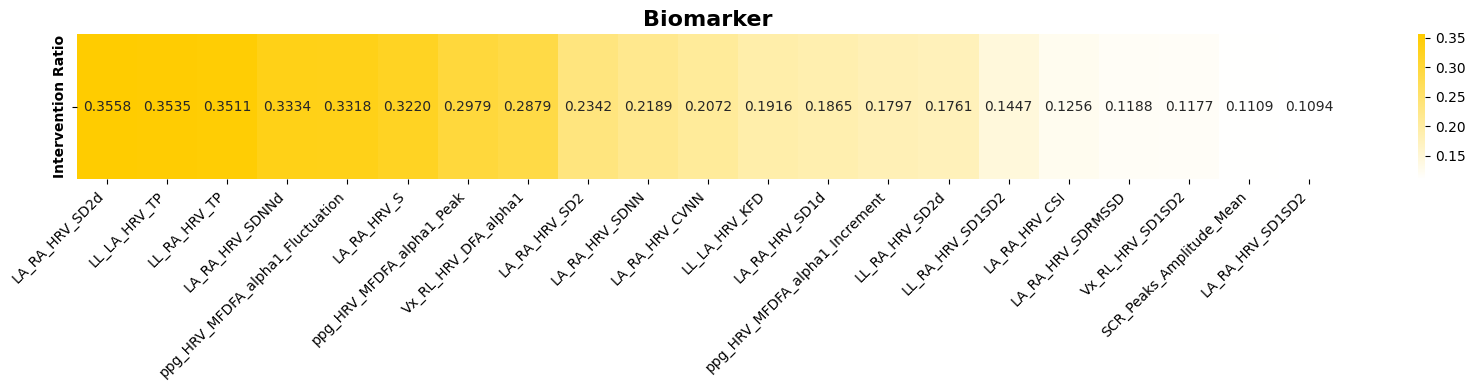

✅ 이미지 'feature_heatmap.png' 저장 및 출력 성공!


In [156]:
plot_intervene_features(intervene_df)